# Burst Detection

ラット中枢神経細胞の分散培養系による神経活動の特徴の一つは，同期バーストである {cite}`Wagenaar2006`．同期バースト（network burstまたは単にburst）は，spikeが高頻度に発火する現象が神経ネットワークの広範囲に伝達する現象を指す．  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.rcParams['font.size'] = 20
plt.rcParams['figure.dpi'] = 140

In [2]:
datadir = '../datasets/01/'
df_map = pd.read_csv(datadir + 'mapping.csv', index_col=0)
df_sp = pd.read_csv(datadir + 'spikes.csv', index_col=0)

In [3]:
def rasterplot(ax: plt.Axes, df: pd.DataFrame, start: float, end: float, x: str='spiketime', y: str='channel', **kwargs):
    df_ = df.query(f'{start} < {x} < {end}')
    return ax.scatter(x=df_[x], y=df_[y], **kwargs)

def spikehist(ax: plt.Axes, df: pd.DataFrame, start: float, end: float, bin_width: float, x: str='spiketime', y: str='channel', smooth=True, **kwargs):
    df_ = df.query(f'{start} < {x} < {end}')
    hist, edges = np.histogram(df_[x], range=(start, end), bins=int((end-start)/bin_width))
    if smooth: hist = gaussian_filter(hist, sigma=[2])  # smoothing with gaussian filter
    return ax .plot(edges[1:], hist, **kwargs)

def rastergram(ax1: plt.Axes, ax2: plt.Axes, df: pd.DataFrame, start: float, end: float, 
               bin_width: float=0.01, x: str='spiketime', y: str='channel', smooth: bool=True):
    p1 = spikehist(ax1, df, start, end, bin_width, x, y, smooth, linewidth=2.0, c='k')
    p2 = rasterplot(ax2, df, start, end, x, y, c='k', s=5)
    ax1.set_xlim(start, end)
    ax1.set_xticks([])
    ax1.set_ylabel('spikes')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_linewidth(2)
    ax1.tick_params(width=2.0, length=5.0, direction='in')

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)

    ax2.set_xlim(start, end)
    ax2.set_xlabel('time [s]')

    for i, tick in enumerate(ax2.xaxis.get_ticklabels()):
        if i % 2 != 0:
            tick.set_visible(False) 

    ax2.set_ylim(0, 1024)
    ax2.set_ylabel('channel #')
    ax2.set_yticks([0, 500, 1000])
    for i, tick in enumerate(ax2.yaxis.get_ticklabels()):
        if i % 2 != 0:
            tick.set_visible(False) 

    ax2.set_facecolor('whitesmoke')
    ax2.tick_params(width=2.0, length=5.0, direction='in')
    return p1, p2

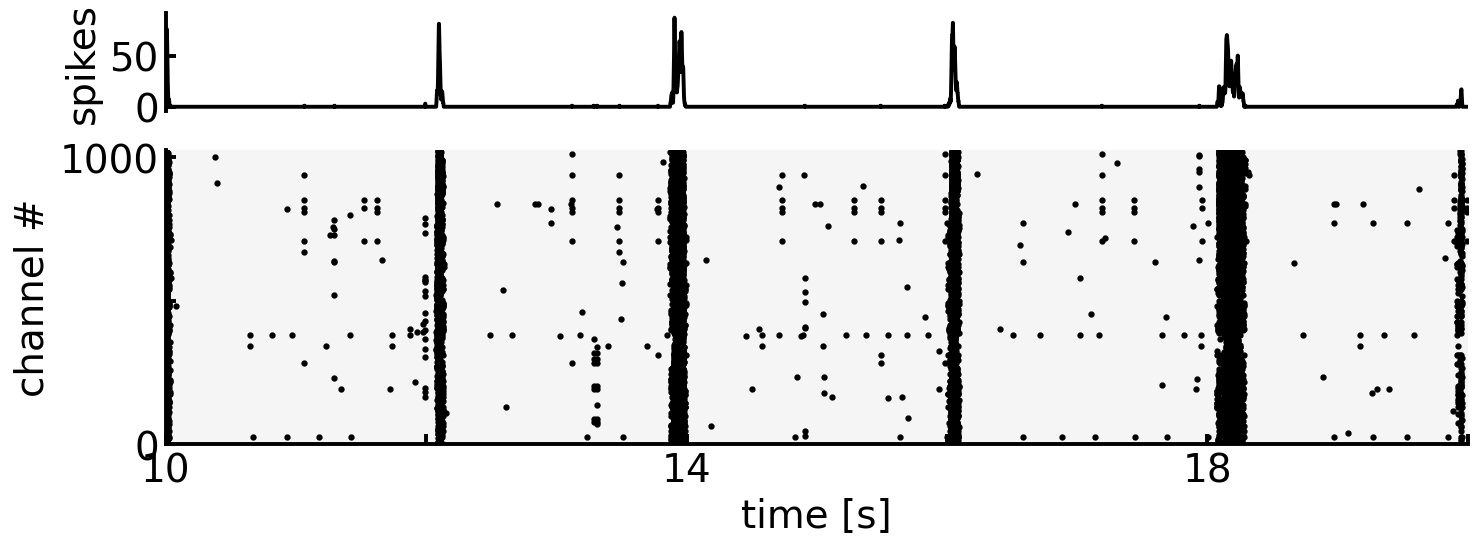

In [4]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 4), gridspec_kw={'height_ratios': [1, 3]})
start, end = 10.0, 20.0
rastergram(ax1=ax1, ax2=ax2, df=df_sp, start=start, end=end, bin_width=0.001)
plt.subplots_adjust(hspace=0.2)
plt.show()

バースト検知のさまざまな手法は {cite}`cotterill2019burst` でレビューされている．

## Thresholding with Global Firing Rate

素朴な方法は，spikeの広域的な発火頻度のヒストグラムを作成し，一定の閾値を超えた区間をburstとみなす方法である {cite}`Chiappalone2005`．  
サンプル間で発火率にバラつきがあるほか，同じサンプルでも広域的な発火頻度には時間的な変動があるため，閾値設定に注意を要する．

In [5]:
def detect_bursts(df: pd.DataFrame, start: float, end: float, bin_width: float, thre: float, smooth: bool=True):
    df_ = df.query(f'{start} < spiketime < {end}')
    hist, edges = np.histogram(df_['spiketime'], range=(start, end), bins=int((end-start)/bin_width))
    if smooth: hist = gaussian_filter(hist, sigma=[2])  # smoothing with gaussian filter
    
    burst_idx = (hist > thre)
    burst_idx = np.append(False, burst_idx)  # handling for the case in which the start is within burst
    burst_idx = np.append(burst_idx, False)  # same as above but for the end
    diff = burst_idx[1:].astype(int) - burst_idx[:-1].astype(int)
    
    burst_start = edges[1:][diff[:-1] == 1]
    burst_end = edges[:-1][diff[1:] == -1]
    burst = np.stack([burst_start, burst_end], axis=1)
    return burst

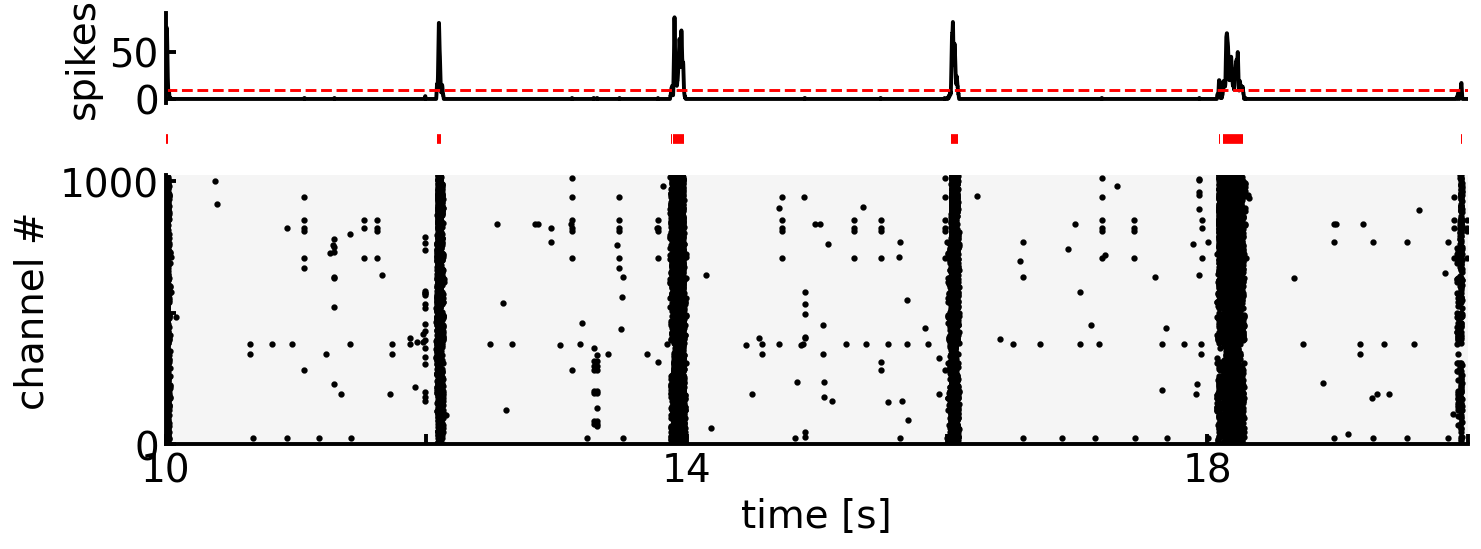

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 4), gridspec_kw={'height_ratios': [1, 0.5, 3]})

start, end = 10.0, 20.0
rastergram(ax1=ax1, ax2=ax3, df=df_sp, start=start, end=end, bin_width=0.001)

thre = 10
ax1.axhline(thre, color='r', linestyle='dashed')

# visualize burst
bursts = detect_bursts(df=df_sp, start=start, end=end, bin_width=0.001, thre=thre)
ax2.hlines(y=[0]*len(bursts), xmin=bursts[:, 0], xmax=bursts[:, 1], colors='r', linewidth=5.0)
ax2.set_xlim(start, end)
ax2.set_axis_off()

plt.subplots_adjust(hspace=0.1)
plt.show()

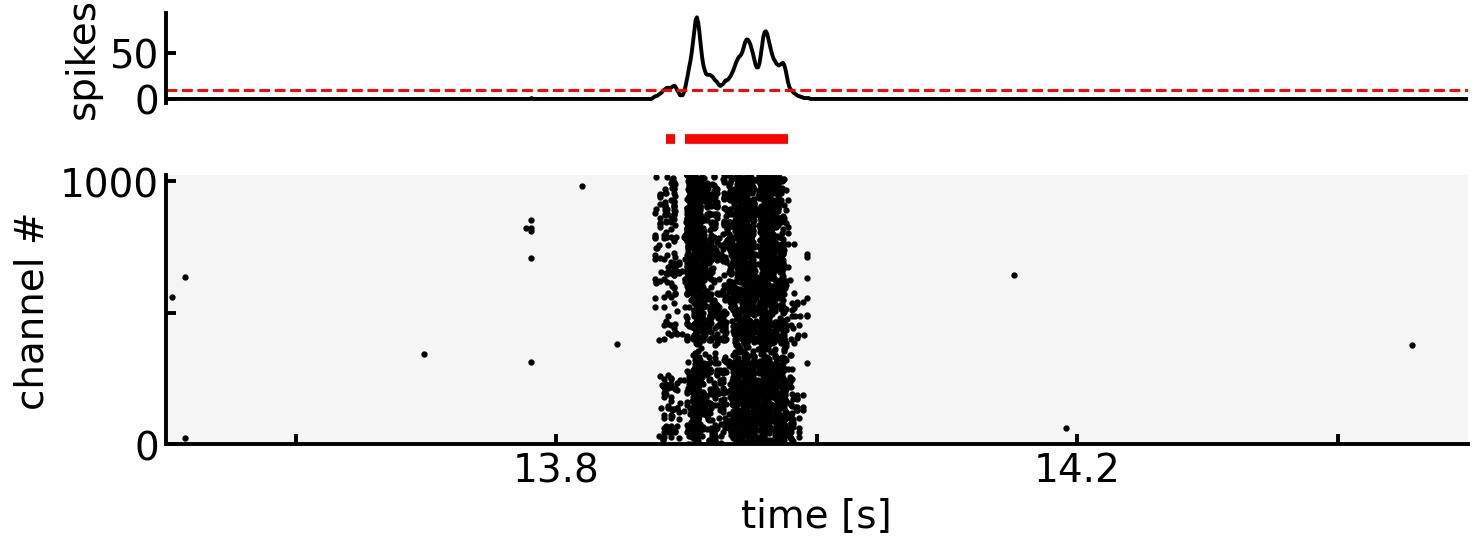

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 4), gridspec_kw={'height_ratios': [1, 0.5, 3]})

start, end = 13.5, 14.5
rastergram(ax1=ax1, ax2=ax3, df=df_sp, start=start, end=end, bin_width=0.001)

thre = 10
ax1.axhline(thre, color='r', linestyle='dashed')
bursts = detect_bursts(df=df_sp, start=start, end=end, bin_width=0.001, thre=thre)

ax2.hlines(y=[0]*len(bursts), xmin=bursts[:, 0], xmax=bursts[:, 1], colors='r', linewidth=5.0)
ax2.set_xlim(start, end)
ax2.set_axis_off()

plt.subplots_adjust(hspace=0.1)
plt.show()

```{note}
Global Firing Rateにより検知されたburst区間は，上記のグラフのように細切れになることがある．  
この際，$T_\theta$以下の期間で連続して発生したburstは同一のburstとみなす，といった処理をはさむことが多い．
```

## Thresholding with ISI

次に，ISI（inter-spike interval）を元にした代表的な手法として，ISInについて述べる {cite}`bakkum2014parameters`．  
ISIを元にした手法の基本的な考えは，バースト中はISIが短くなり，バースト外ではISIが長くなるため，ISIのヒストグラムは多くの場合，二峰性（bi-modal）の分布を取るというものである．二峰性の分布における二つの山の間が，バースト内外を隔てるISIの閾値であると考える．

In [8]:
import statsmodels.api as sm
from scipy.signal import argrelextrema

In [9]:
class ISIn:
    def __init__(self, df, column='spiketime') -> None:
        self.spiketime = df[column].sort_values().values * 1000.0  # convert to ms
        
    def _hist(self, n, xmin=-1, xmax=4):
        isi_n = self.spiketime[n - 1:] - self.spiketime[:1 - n]
        hist, edges = np.histogram(isi_n, bins=np.logspace(xmin, xmax, 100))
        x = edges[1:]
        y = hist / np.sum(hist)
        
        lowess = sm.nonparametric.lowess
        filtered = lowess(y, x, is_sorted=True, frac=0.1, it=0)  # smoothing by lowess
        return filtered
    
    def plot(self, ax, n_list, xmin=-1, xmax=4, ymin=-7, ymax=0, cmap=None, **kwargs):     
        if cmap is None: cmap = plt.get_cmap('tab10') 
        data = []
        for i, n in enumerate(n_list):
            filtered = self._hist(n=n, xmin=xmin, xmax=xmax)
            ax.plot(filtered[:, 0], filtered[:, 1], c=cmap(i/len(n_list)), label=f'$N={n}$', **kwargs)
            data.append(filtered)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("$ISI_N [ms]$")
        ax.set_ylabel("probability [%]")
        ax.set_xlim(10 ** xmin, 10 ** xmax)
        ax.set_ylim(10 ** ymin, 10 ** ymax)
        ax.legend()
        ax.grid()
        return np.array(data)
    
    def detect_bursts(self, n, thre, return_idx=False):
        n_spikes = len(self.spiketime)
        burst_idx = np.zeros(n_spikes, dtype=bool)

        for i in range(n_spikes - n + 1):
            if self.spiketime[i + n - 1] - self.spiketime[i] <= thre:
                burst_idx[i : i + n] = True

        burst_idx = np.append(False, burst_idx)
        burst_idx = np.append(burst_idx, False)
        if return_idx: return burst_idx
        
        diff = burst_idx[1:].astype(int) - burst_idx[:-1].astype(int)
        burst_start_idx = (diff[:-1] == 1)
        burst_end_idx = (diff[1:] == -1)

        burst_start = self.spiketime[burst_start_idx]
        burst_end = self.spiketime[burst_end_idx]
        burst = np.stack([burst_start, burst_end], axis=1)
        return burst

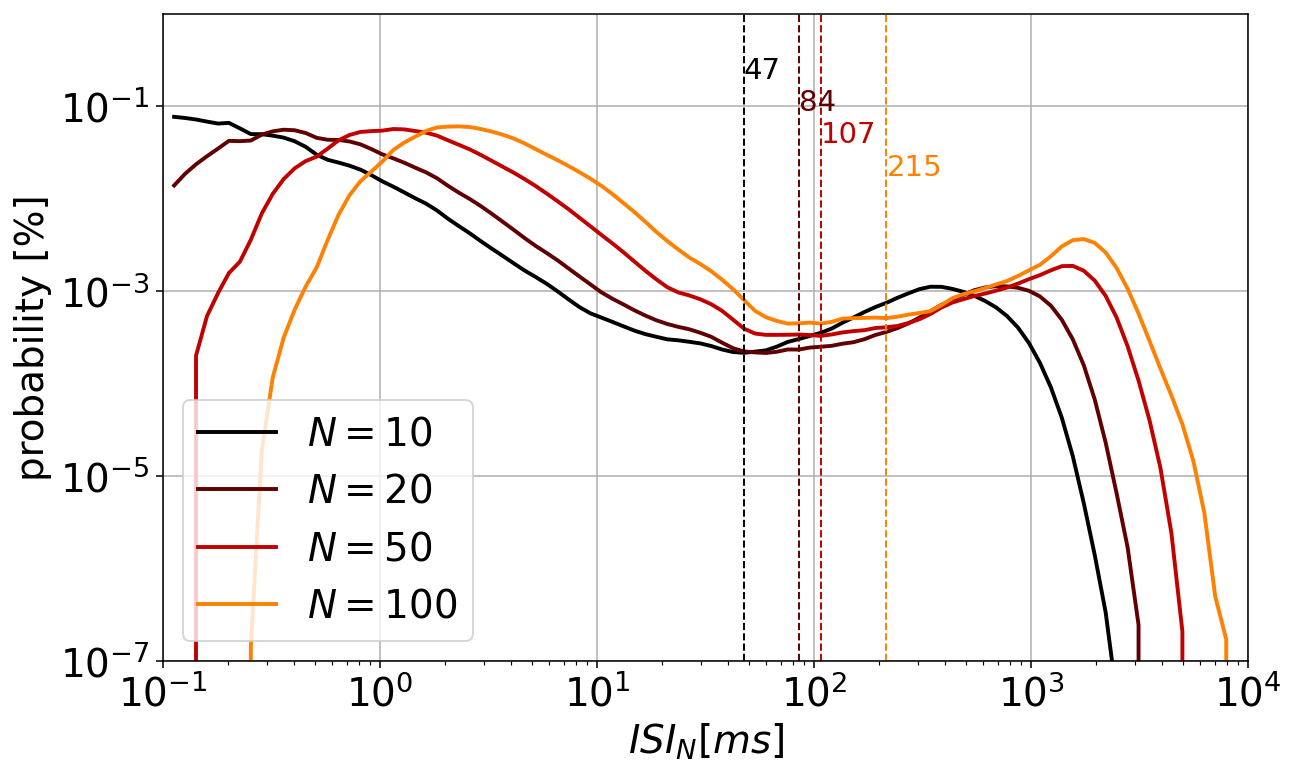

In [10]:
detector = ISIn(df_sp)
n_list = [10, 20, 50, 100]
thre_list = []

fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.get_cmap('gist_heat')
data = detector.plot(ax=ax, n_list=n_list, cmap=cmap, linewidth=2.0)

for i, filtered in enumerate(data):
    x, y = filtered[:, 0], filtered[:, 1]
    
    # detect local minima of smoothed histogram as the ISIn threshold
    idx_min = argrelextrema(y, np.less)[0][-1]
    x_min = x[idx_min]
    thre_list.append(x_min)
    
    ax.axvline(x=x_min, linestyle='dashed', linewidth=1.0, c=cmap(i/len(data)))
    ax.text(x=x_min, y=0.9-i*0.05, s=f'{int(x_min)}', fontsize=15, transform=ax.get_xaxis_transform(), c=cmap(i/len(data)))
    
plt.show()

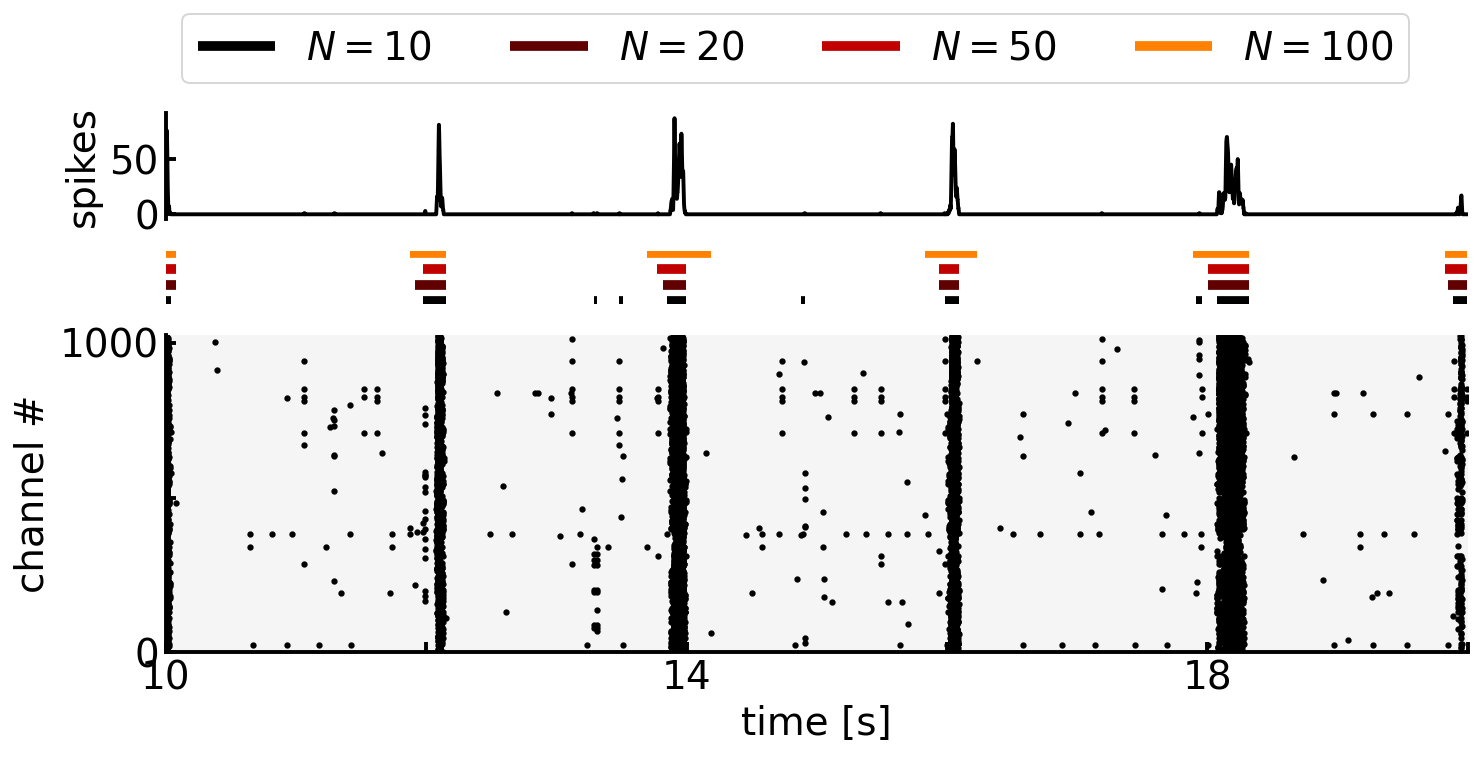

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 5), gridspec_kw={'height_ratios': [1, 0.5, 3]})

start, end = 10.0, 20.0
detector = ISIn(df_sp.query(f'{start} <= spiketime <= {end}'))
rastergram(ax1=ax1, ax2=ax3, df=df_sp, start=start, end=end, bin_width=0.001)

for i, (n, thre) in enumerate(zip(n_list, thre_list)):
    bursts = detector.detect_bursts(n, thre) / 1000.0
    ax2.hlines(y=[2*i]*len(bursts), xmin=bursts[:, 0], xmax=bursts[:, 1],
               linewidth=5.0, colors=cmap(i/len(data)), label=f'$N={n}$')

ax2.set_xlim(start, end)
ax2.set_axis_off()

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(n_list), bbox_to_anchor=(0.5, 1.05))

plt.subplots_adjust(hspace=0.2)
plt.show()

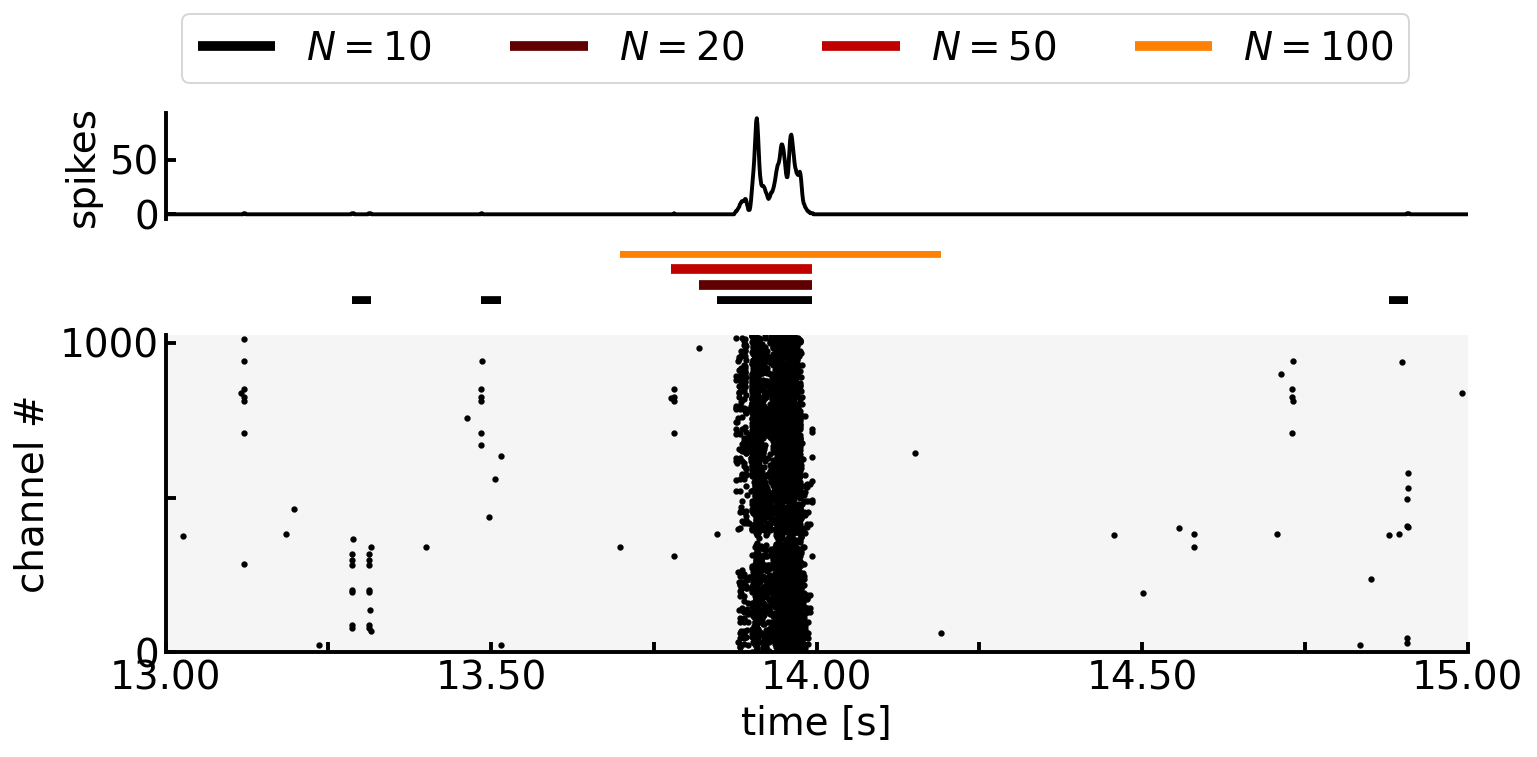

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 5), gridspec_kw={'height_ratios': [1, 0.5, 3]})

start, end = 13.0, 15.0
detector = ISIn(df_sp.query(f'{start} <= spiketime <= {end}'))
rastergram(ax1=ax1, ax2=ax3, df=df_sp, start=start, end=end, bin_width=0.001)

for i, (n, thre) in enumerate(zip(n_list, thre_list)):
    bursts = detector.detect_bursts(n, thre) / 1000.0
    ax2.hlines(y=[2*i]*len(bursts), xmin=bursts[:, 0], xmax=bursts[:, 1],
               linewidth=5.0, colors=cmap(i/len(data)), label=f'$N={n}$')

ax2.set_xlim(start, end)
ax2.set_axis_off()

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(n_list), bbox_to_anchor=(0.5, 1.05))

plt.subplots_adjust(hspace=0.2)
plt.show()

---
```{bibliography}
:filter: docname in docnames
```